In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from utilities3 import LpLoss
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from sklearn.model_selection import train_test_split
from functools import reduce
from functools import partial
import operator
from timeit import default_timer
from matplotlib.ticker import FormatStrFormatter
import deepxde as dde

Using backend: pytorch



In [2]:
def set_size(width, fraction=1, subplots=(1, 1), height_add=0):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = height_add + fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

In [445]:
# Solves the PDE for a single instance of theta and kappa. Returns solution and control values
def solvePDE(f, kappa, init_condition, x, t, controlFunc, param, dx, printFreq=5):
    nx = len(x)
    nt = len(t)
    u = np.zeros((nt, nx))
    # Set intial condition
    for i in range(nx):
        u[0][i] = init_condition[i]
    print("Solving PDE... Timesteps Needed:", nt, flush=True)
    for i in range(1, nt):
        if i%int(nt/printFreq) == 0:
            print("Completed:", i, "/", nt, flush=True)
            
        u[i][-1] = controlFunc(u[i-1], param, nx, dx)
        fres = np.zeros(nx)
        for j in range(0, nx-1):
            fres[j] = sum(f[j][0:j]*u[i-1][0:j])*dx
        u[i][0:nx-1] = u[i-1][0:nx-1] + dt*((u[i-1][1:nx] - u[i-1][0:nx-1])/dx + fres[0:nx-1])
    return u

def solveBetaFunction(x, gamma, amp):
    beta = np.zeros(len(x))
    for idx, val in enumerate(x):
        beta[idx] = amp*math.cos(gamma*math.acos(val))
    return beta

def buildF(x, gamma1, amp1, gamma2, amp2):
    b1 = solveBetaFunction(x, gamma1, amp1)
    b2 = solveBetaFunction(x, gamma2, amp2)
    nx = len(x)
    f = np.zeros((nx, nx))
    for idx, val in enumerate(x):
        for idx2, val2 in enumerate(x):
            if idx > idx2:
                f[idx][idx2] = b1[idx]*b2[idx2]
    return f

def fastKernelCalc(f, x, dx):
    nx = len(x) 
    kappa = np.zeros((nx, nx))
    f2 = f.transpose()
    for i in range(nx):
        for j, xj in enumerate(x):
            kernel = 0
            if i-j>0 and j!=0:
                kernel -= sum(np.diagonal(f, offset=j-i)[0:j])*dx
                for k in range(0, j):
                    kernel += sum(f2[k][k:k+i-j]*kappa[i-j+k][k:k+i-j])*dx*dx
            kappa[i][j] = kernel
    return kappa
                
def solveOpenLoop(_, _a, _b, _c):
    return 0

def solveControl(u, kernel, nx, dx):
    return sum(kernel[-1][0:nx]*u[0:nx])*dx

# PDE L2 Error
def getPDEl2(u, uhat):
    pdeError = np.zeros(nt-1)
    for i in range(1, nt):
        error = 0
        for j in range(nx):
            error += (u[i][j] - uhat[i][j])**2
        error = np.sqrt(error*0.01)
        pdeError[i-1] = error
    return pdeError

def getKernelError(k1, k2):
    nx = len(k1[0])
    kernelError = np.zeros(nx-1)
    for i in range(1, nx):
        error = 0
        for j in range(i):
            error += (k1[i][j] - k2[i][j])**2
        error = np.sqrt(error)/i
        kernelError[i-1] = error
    return kernelError

def zeroToNan(x):
    for i in range(len(x)):
        for j in range(len(x[0])):
            if j >= i:
                x[i][j] = float('nan')
    return x

In [448]:
X = 1
dx = 0.01
nx = int(round(X/dx))+1
spatial = np.linspace(0, X, nx)
T = 2
dt = 0.0001
nt = int(round(T/dt))
temporal = np.linspace(0, T, nt)
ndata = 1000

# Dataset Generation. Uncomment if you want to make your own dataset. Will take about 10-15 minutes for 1k instances.

x = []
y = [] 
for i in range(ndata):
    if i % 100 == 0:
        print("Completed", i, "/", ndata)
    f = buildF(spatial, np.random.uniform(3, 6),4, np.random.uniform(3, 6), 4)
    kernel = fastKernelCalc(f, spatial, dx)
    x.append(f)
    y.append(kernel)
    
x = np.array(x)
x = x.reshape(x.shape[0], -1)
y = np.array(y)
y = y.reshape(y.shape[0], -1)
np.savetxt("x.dat", x)
np.savetxt("y.dat", y)

Completed 0 / 1000
Completed 100 / 1000
Completed 200 / 1000
Completed 300 / 1000
Completed 400 / 1000
Completed 500 / 1000
Completed 600 / 1000
Completed 700 / 1000
Completed 800 / 1000
Completed 900 / 1000


In [450]:
# Parameters
epochs =500
ntrain = 900
ntest = 100
batch_size = 20
gamma = 0.5
learning_rate = 0.001
step_size= 50
modes=12
width=32

X = 1
dx = 0.01
nx = int(round(X/dx))+1
grids = []
grids.append(np.linspace(0, 1, nx, dtype=np.float32))
grids.append(np.linspace(0, 1, nx, dtype=np.float32))
grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T
grid = torch.from_numpy(grid).cuda()

torch.Size([10201, 2])


In [451]:
# Create train/test splits
x = np.loadtxt("x.dat", dtype=np.float32)
y = np.loadtxt("y.dat", dtype=np.float32)
x = x.reshape(x.shape[0], x.shape[1] // nx, nx)
y = y.reshape(y.shape[0], y.shape[1]// nx, nx)
x = np.array(x, dtype=np.float32).reshape(ndata, nx*nx)
y = np.array(y, dtype=np.float32).reshape(ndata, nx*nx)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))

(1000, 10201)
(1000, 10201)


In [452]:
def count_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [453]:
class BranchNet(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
        self.conv1 = torch.nn.Conv2d(1, 64, 5, stride=2)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(64,128, 5, stride=2)
        self.fc1 = torch.nn.Linear(67712, 1028)
        self.fc2 = torch.nn.Linear(1028, 256)
        
    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], 1, self.shape, self.shape))
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [454]:
# Define a sequential torch network for batch and trunk. Can use COV2D which we will show later
dim_x = 2
m = nx*nx

branch = BranchNet(nx)

model = dde.nn.DeepONetCartesianProd([m, branch], [dim_x, 128, 256, 256], "relu", "Glorot normal").cuda()
print(count_params(model))

70178181


In [455]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [456]:
loss = torch.nn.MSELoss()
train_lossArr = []
test_lossArr = []
time_Arr = []

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_loss = 0
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model((x, grid))
        
        lp = loss(out, y)
        lp.backward()
        
        optimizer.step()
        train_loss += lp.item()
        
    scheduler.step()
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in testData:
            x, y = x.cuda(), y.cuda()
            
            out = model((x, grid))
            test_loss += loss(out, y).item()
            
    train_loss /= len(trainData)
    test_loss /= len(testData)
    
    train_lossArr.append(train_loss)
    test_lossArr.append(test_loss)
    
    t2 = default_timer()
    time_Arr.append(t2-t1)
    if ep%50 == 0:
        print(ep, t2-t1, train_loss, test_loss)

0 0.6045770531054586 353.6994665463765 2.1782670259475707
50 0.5780982330907136 0.018397620216839845 0.016831221245229244
100 0.5708229980664328 0.005046856289522515 0.0059770911931991575
150 0.5651206549955532 0.003495089119921128 0.004313283832743764
200 0.5801794109866023 0.0024188860345424877 0.003067153599113226
250 0.5701289840508252 0.002423054160964158 0.0025910885306075215
300 0.571765512926504 0.0016471109818667173 0.002180437627248466
350 0.5787187439855188 0.0015075375351847873 0.0020098010543733837
400 0.5677396859973669 0.001379759451891813 0.0019310020608827472
450 0.5756572510581464 0.0013064960742162333 0.0018332905368879438


Avg Epoch Time: 0.5747797157634049
Final Testing Loss: 0.009147236123681068
Final Training Loss: 0.05697478132788092


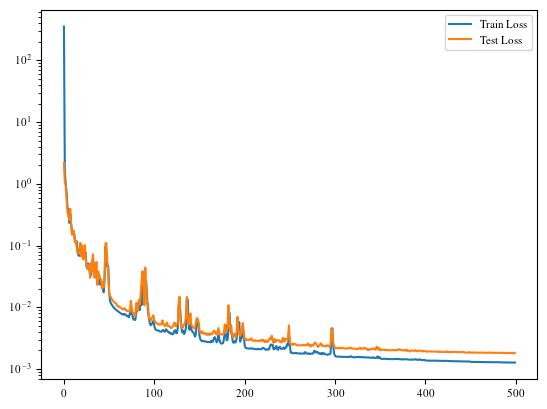

In [457]:
# Display Model Details
plt.figure()
plt.plot(train_lossArr, label="Train Loss")
plt.plot(test_lossArr, label="Test Loss")
plt.yscale("log")
plt.legend()

testLoss = 0
trainLoss = 0
with torch.no_grad():
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()

        out = model((x, grid))
        trainLoss += loss(out, y).item()
        
    for x, y in testData:
        x, y = x.cuda(), y.cuda()

        out = model((x, grid))
        testLoss += loss(out, y).item()
    
    
print("Avg Epoch Time:", sum(time_Arr)/len(time_Arr))
print("Final Testing Loss:", testLoss)
print("Final Training Loss:", trainLoss)

In [458]:
X1 = 1
dx1 = 0.002
nx1 = int(round(X1/dx1))+1
spatial1 = np.linspace(0, X1, nx1)
T1 = 2
dt1 = 0.0001
nt1 = int(round(T1/dt1))
temporal1 = np.linspace(0, T1, nt1)

# Suffix 1 indicates high resolution. They will take much longer to generate 
# (10-15 minutes or so for kernel1 calculation) and can be commented on slower machines. 
# if commented, notice that u3 will need to be commented and in the third figure replace u3 with u
f = buildF(spatial, 6,4, 6, 4)
f1 = buildF(spatial1, 6,4, 6, 4)

print("finished f")
kernel = fastKernelCalc(f, spatial, dx)
kernel1 = fastKernelCalc(f1, spatial1, dx1)

xdata = np.array(f, dtype=np.float32)
xdata = torch.from_numpy(xdata.reshape((1, nx*nx))).cuda()
ydata = model((xdata, grid))
ydata = ydata.detach().cpu().numpy().reshape(nx, nx)

finished f


In [459]:
init_cond = np.zeros(1001)
init_cond.fill(10)
printFreq = 10

# u is solved with analytical kernel with non-fine resolution
# u2 is solved with kernel with neural operator
# u3 is solved with analytical kernel with super-fine resolution
u = solvePDE(f, kernel, init_cond, spatial, temporal, solveControl, kernel, dx, printFreq)
u2 = solvePDE(f, ydata, init_cond, spatial, temporal, solveControl, ydata, dx)
u3 = solvePDE(f1, kernel1, init_cond, spatial1, temporal1, solveControl, kernel1, dx1, printFreq)

Solving PDE... Timesteps Needed: 20000
Completed: 2000 / 20000
Completed: 4000 / 20000
Completed: 6000 / 20000
Completed: 8000 / 20000
Completed: 10000 / 20000
Completed: 12000 / 20000
Completed: 14000 / 20000
Completed: 16000 / 20000
Completed: 18000 / 20000
Solving PDE... Timesteps Needed: 20000
Completed: 4000 / 20000
Completed: 8000 / 20000
Completed: 12000 / 20000
Completed: 16000 / 20000
Solving PDE... Timesteps Needed: 20000
Completed: 2000 / 20000
Completed: 4000 / 20000
Completed: 6000 / 20000
Completed: 8000 / 20000
Completed: 10000 / 20000
Completed: 12000 / 20000
Completed: 14000 / 20000
Completed: 16000 / 20000
Completed: 18000 / 20000


In [460]:
# Generate OpenLoop PDE Solution 

dt0 = 0.0001
T0 = 5
nt0 = int(round(T0/dt0))
temporal0 = np.linspace(0, T0, nt0)
uopen = solvePDE(f, kernel, init_cond, spatial, temporal0, solveOpenLoop, kernel, dx, printFreq)

Solving PDE... Timesteps Needed: 50000
Completed: 5000 / 50000
Completed: 10000 / 50000
Completed: 15000 / 50000
Completed: 20000 / 50000
Completed: 25000 / 50000
Completed: 30000 / 50000
Completed: 35000 / 50000
Completed: 40000 / 50000
Completed: 45000 / 50000


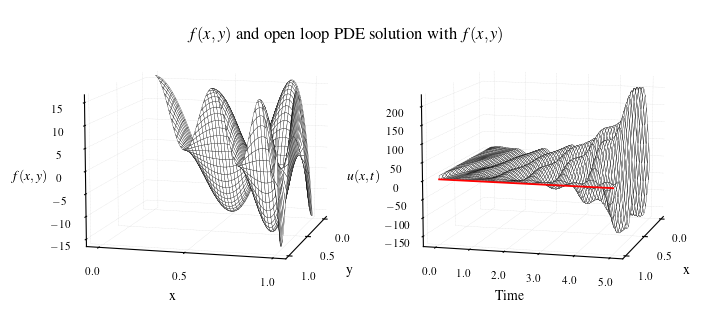

In [461]:
res = 1
fig = plt.figure(figsize=set_size(516, 0.99, (1, 2), height_add=1))
plt.subplots_adjust(left=0.09, bottom=0, right=1, top=1.1, wspace=0.1, hspace=0)
subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)

meshx, mesht = np.meshgrid(spatial, spatial)
subfig = subfigs
subfig.suptitle(r"$f(x,y)$ and open loop PDE solution with $f(x, y)$")
ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})
ax[0].plot_surface(meshx, mesht, zeroToNan(f), edgecolor="black",lw=0.2, rstride=2, cstride=2, 
                        alpha=1, color="white", shade=False, rasterized=True)
for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
    
    
meshx, mesht = np.meshgrid(spatial, temporal0)

ax[0].view_init(10,15)
ax[0].set_xlabel("y")
ax[0].set_ylabel("x")
ax[0].set_zlabel(r"$f(x, y)$")
ax[0].set_xticks([0, 0.5, 1])
ax[0].set_yticks([0, 0.5, 1])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


ax[1].plot_surface(meshx, mesht, uopen, edgecolor="black",lw=0.2, rstride=400, cstride=4, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(nt0)
vals = (uopen.transpose())[-1] 
ax[1].plot(test[1:], temporal0[1:], vals[1:], color="red", lw=1.3, antialiased=True)
ax[1].view_init(10, 15)
ax[1].set_xlabel("x")
ax[1].set_ylabel("Time")
ax[1].set_zlabel(r"$u(x, t)$")
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

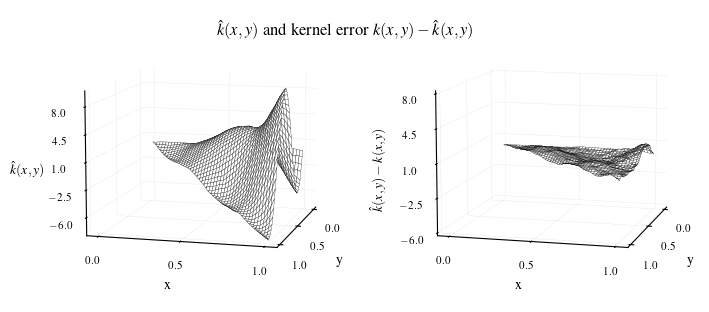

In [465]:
res = 1
fig = plt.figure(figsize=set_size(516, 0.99, (1, 2), height_add=1))
plt.subplots_adjust(left=0.09, bottom=0, right=1, top=1.1, wspace=0.2, hspace=0)
subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)

meshx, mesht = np.meshgrid(spatial, spatial)
subfig = subfigs
subfig.suptitle(r"$\hat{k}(x, y)$ and kernel error $k(x, y) - \hat{k}(x, y)$")
ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})
ax[0].plot_surface(meshx, mesht, zeroToNan(ydata), edgecolor="black",lw=0.2, rstride=2, cstride=2, 
                        alpha=1, color="white", shade=False, rasterized=True)
for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
    
    

ax[0].view_init(10,15)
ax[0].set_xlabel("y")
ax[0].set_ylabel("x")
ax[0].set_zlabel(r"$\hat{k}(x, y)$")
ax[0].set_xticks([0, 0.5, 1])
ax[0].set_yticks([0, 0.5, 1])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax[1].plot_surface(meshx, mesht, zeroToNan(ydata-kernel), edgecolor="black",lw=0.2, rstride=2, cstride=2, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
ax[1].view_init(10, 15)
ax[1].set_xlabel("y")
ax[1].set_ylabel("x")
ax[1].zaxis.set_rotate_label(False) 
ax[1].set_zlabel(r"$\hat{k}(x,y) - k(x, y)$", rotation=90)
ax[1].set_xticks([0, 0.5, 1])
ax[1].set_yticks([0, 0.5, 1])
ax[0].set_yticks([0, 0.5, 1])

ax[1].set_zticks(np.linspace(-6, 8, 5))
ax[0].set_zticks(np.linspace(-6, 8, 5))
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

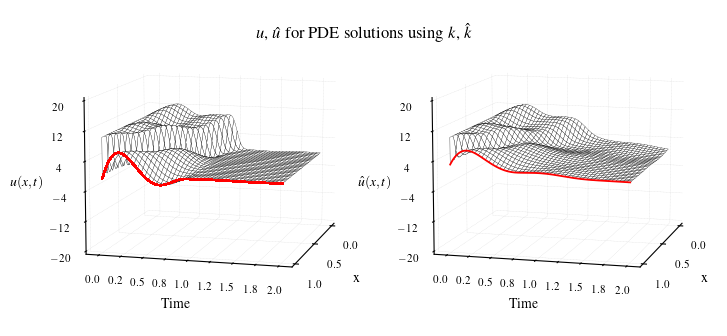

In [463]:
res = 1
fig = plt.figure(figsize=set_size(516, 0.99, (1, 1), height_add=-1))
plt.subplots_adjust(left=0.06, bottom=0, right=1, top=1.1, wspace=0.1, hspace=0)
subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)

meshx, mesht = np.meshgrid(spatial, temporal)
meshx1, mesht1 = np.meshgrid(spatial1, temporal1)
subfig = subfigs
subfig.suptitle(r"$u$, $\hat{u}$ for PDE solutions using $k$, $\hat{k}$")
ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})
ax[0].plot_surface(meshx1, mesht1, u3, edgecolor="black",lw=0.2, rstride=400, cstride=20, 
                        alpha=1, color="white", shade=False, rasterized=True)
for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
    
    
test = np.ones(nt1)
vals = (u3.transpose())[-1] 
zticks = np.linspace(-20, 20, 6)
ax[0].plot(test[1:], temporal1[1:], vals[1:], color="red", lw=1.3, antialiased=False, rasterized=False)
ax[0].view_init(10,15)
ax[0].set_xlabel("x")
ax[0].set_ylabel("Time")
ax[0].set_zlabel(r"$u(x, t)$")
ax[0].set_xticks([0, 0.5, 1])
ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].plot_surface(meshx, mesht, u2, edgecolor="black",lw=0.2, rstride=400, cstride=4, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(nt)
vals = (u2.transpose())[-1] 
ax[1].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
ax[1].view_init(10, 15)
ax[1].set_xlabel("x")
ax[1].set_ylabel("Time")
ax[1].set_zlabel(r"$\hat{u}(x, t)$")
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])
ax[1].set_zticks(zticks)
ax[0].set_zticks(zticks)

ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

In [464]:
torch.save(model.state_dict(), "fToKTorchModel")